## Загрузим нужные библиотеки

In [ ]:
!pip install catboost
!pip install openpyxl
!pip install shap

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score

import numpy as np
from sklearn.datasets import make_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import seaborn as sns
import matplotlib.pylab as plt

from tqdm.notebook import trange, tqdm
from catboost import CatBoostRegressor, CatBoostClassifier
import holidays
import matplotlib.pyplot as plt
import shap
import copy
import shap

np.random.seed(0)

tqdm.pandas()
%matplotlib inline

## Загрузим данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/train_dataset_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/test_dataset_test.csv")

## Рассмотрим датасет по ближе

In [ ]:
df_train.head(3)

,id,Дата,Время,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,...,year_18,year_19,year_20,sin_day,sin_month,sin_week,sin_weekday,sin_hour,sin_min,Праздник
0,490103984,13.07.2018,17:35:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,88,NaN,NaN,NaN,Столкновение,...,1.0,0.0,0.0,0.440783,-0.5,-0.226710,-0.433884,-0.965926,-0.500000,0
1,490097169,11.05.2018,17:10:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,73,NaN,NaN,NaN,Столкновение,...,1.0,0.0,0.0,0.858706,-0.5,-0.762162,0.000000,-0.965926,0.866025,0
2,490031781,25.01.2020,14:44:00,"Новгородская область, Великий Новгород",Хутынская ул,29,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,-0.899878,0.5,0.463083,-0.974928,-0.500000,-0.994522,0


In [ ]:
df_train.shape

(19996, 166)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19996 entries, 0 to 19995
Columns: 166 entries, id to Праздник
dtypes: float64(143), int64(16), object(7)
memory usage: 25.3+ MB


In [ ]:
df_train["Погибло"].value_counts()

0    35426
1      299
2       35
3       11
Name: Погибло, dtype: int64

In [ ]:
df_train["Погибло детей"].value_counts()

0    35759
1       12
Name: Погибло детей, dtype: int64

In [ ]:
df_train["Ранено"].value_counts()

0    31229
1     3473
2      733
3      217
4       76
5       28
6        9
8        3
7        3
Name: Ранено, dtype: int64

In [ ]:
df_train["Ранено детей"].value_counts()

0    34994
1      678
2       86
3        7
4        6
Name: Ранено детей, dtype: int64

## Обработка дубликатов

In [ ]:
df_train.drop_duplicates(inplace=True)
df_train.reset_index(drop=True, inplace=True)

In [ ]:
common_rows = pd.merge(df_test, df_train, how='inner', on=['Дата', 'Время', 'Место', 'Улица', 'Дом', 'Дорога', 'Вид ДТП', 'Километр', 'Метр']).rename({'id_x': 'id'}, axis=1)

## Даные с сайта ГИБДД

In [ ]:
import json
with open('/content/drive/MyDrive/ColabNotebooks/DTP/novgorodskaia-oblast.geojson') as f:
    data = json.load(f)

In [ ]:
df_train['datetime'] = pd.to_datetime(df_train['Дата'] + ' ' + df_train['Время'])
df_test['datetime'] = pd.to_datetime(df_test['Дата'] + ' ' + df_test['Время'])

In [ ]:
participants_count = []
dead_count = []
injured_count = []
severities = []
road_conditions = []
weathers = []
categories = []
roads = []
kilos = []
streets = []
places = []
numbers = []

for row in tqdm(df_train[['datetime', 'Вид ДТП', 'Дорога', 'Место']].values):
  flag = False
  for obj in data['features']:
    time = obj['properties']['datetime']
    type_DTP = obj['properties']['category']

    if time == str(row[0]):
      flag = True
      if type(obj['properties']['address']) == str:
        address = obj['properties']['address'].split(',')
        if len(address) == 2:
          roads.append(address[0])
          kilos.append(address[1].strip().strip().split(' ')[0])
          streets.append(np.nan)
          places.append(np.nan)
          numbers.append(np.nan)
        elif len(address) == 3:
          places.append(address[0])
          street = address[1].split(' ')
          streets.append(' '.join(street[2:]) + ' ' + street[1])
          numbers.append(address[2].strip())
          roads.append(np.nan)
          kilos.append(np.nan)
        else:
          roads.append(np.nan)
          kilos.append(np.nan)
          streets.append(np.nan)
          places.append(np.nan)
          numbers.append(np.nan)
      else:
        roads.append(np.nan)
        kilos.append(np.nan)
        streets.append(np.nan)
        places.append(np.nan)
        numbers.append(np.nan)

      participants_count.append(obj['properties']['participants_count'])
      dead_count.append(obj['properties']['dead_count'])
      injured_count.append(obj['properties']['injured_count'])
      severities.append(obj['properties']['severity'])
      road_conditions.append(obj['properties']['road_conditions'][0])
      weathers.append(obj['properties']['weather'][0])
      categories.append(obj['properties']['category'])
      break

  if flag == False:
    roads.append(np.nan)
    kilos.append(np.nan)
    streets.append(np.nan)
    places.append(np.nan)
    numbers.append(np.nan)
    participants_count.append(np.nan)
    dead_count.append(np.nan)
    injured_count.append(np.nan)
    severities.append(np.nan)
    road_conditions.append(np.nan)
    weathers.append(np.nan)
    categories.append(np.nan)

new_train_data = pd.DataFrame({'road': roads, 'kilo':kilos , 'street': streets, 'place': places, 'number': numbers,
                               'participants_count': participants_count, 'severity': severities, 'road_conditions': road_conditions, 
                               'weather': weathers, 'category': categories, 'dead_count': dead_count, 
                               'injured_count': injured_count})

  0%|          | 0/19996 [00:00<?, ?it/s]

In [ ]:
participants_count = []
dead_count = []
injured_count = []
severities = []
road_conditions = []
weathers = []
categories = []
roads = []
kilos = []
streets = []
places = []
numbers = []

for row in tqdm(df_test[['datetime', 'Вид ДТП', 'Дорога', 'Место']].values):
  flag = False
  for obj in data['features']:
    time = obj['properties']['datetime']
    type_DTP = obj['properties']['category']

    if time == str(row[0]):
      flag = True
      if type(obj['properties']['address']) == str:
        address = obj['properties']['address'].split(',')
        if len(address) == 2:
          roads.append(address[0])
          kilos.append(address[1].strip().strip().split(' ')[0])
          streets.append(np.nan)
          places.append(np.nan)
          numbers.append(np.nan)
        elif len(address) == 3:
          places.append(address[0])
          street = address[1].split(' ')
          streets.append(' '.join(street[2:]) + ' ' + street[1])
          numbers.append(address[2].strip())
          roads.append(np.nan)
          kilos.append(np.nan)
        else:
          roads.append(np.nan)
          kilos.append(np.nan)
          streets.append(np.nan)
          places.append(np.nan)
          numbers.append(np.nan)
      else:
        roads.append(np.nan)
        kilos.append(np.nan)
        streets.append(np.nan)
        places.append(np.nan)
        numbers.append(np.nan)

      participants_count.append(obj['properties']['participants_count'])
      dead_count.append(obj['properties']['dead_count'])
      injured_count.append(obj['properties']['injured_count'])
      severities.append(obj['properties']['severity'])
      road_conditions.append(obj['properties']['road_conditions'][0])
      weathers.append(obj['properties']['weather'][0])
      categories.append(obj['properties']['category'])
      break

  if flag == False:
    roads.append(np.nan)
    kilos.append(np.nan)
    streets.append(np.nan)
    places.append(np.nan)
    numbers.append(np.nan)
    participants_count.append(np.nan)
    dead_count.append(np.nan)
    injured_count.append(np.nan)
    severities.append(np.nan)
    road_conditions.append(np.nan)
    weathers.append(np.nan)
    categories.append(np.nan)

new_test_data = pd.DataFrame({'road': roads, 'kilo':kilos , 'street': streets, 'place': places, 'number': numbers,
                               'participants_count': participants_count, 'severity': severities, 'road_conditions': road_conditions, 
                               'weather': weathers, 'category': categories, 'dead_count': dead_count, 
                               'injured_count': injured_count})

  0%|          | 0/6788 [00:00<?, ?it/s]

## Обработаем дату и время

In [ ]:
df_train['День'] = pd.to_datetime(df_train['Дата']).dt.strftime("%d").astype(int)
df_train['Неделя'] = pd.to_datetime(df_train['Дата']).apply(lambda x: x.week)
df_train['Неделя месяца'] = df_train['Дата'].apply(lambda d: (pd.to_datetime(d).day-1) // 7 + 1)
df_train['Месяц'] = pd.to_datetime(df_train['Дата']).dt.strftime("%m").astype(int)
df_train['Год'] = pd.to_datetime(df_train['Дата']).dt.strftime("%y").astype(int)
df_train["Год_Месяц"] = df_train["Дата"].apply(lambda x: x.split()[0][:-3])
df_train["Сезон"] = df_train['Месяц'].apply(lambda x: x // 3)
df_train['День недели'] = pd.to_datetime(df_train['Дата']).apply(lambda x: x.weekday())
df_train["Код_даты"] = pd.to_datetime(df_train["Дата"]).astype(int) / 1000000000

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


In [ ]:
df_test['День'] = pd.to_datetime(df_test['Дата']).dt.strftime("%d").astype(int)
df_test['Неделя'] = pd.to_datetime(df_test['Дата']).apply(lambda x: x.week)
df_test['Неделя месяца'] = df_test['Дата'].apply(lambda d: (pd.to_datetime(d).day-1) // 7 + 1)
df_test['Месяц'] = pd.to_datetime(df_test['Дата']).dt.strftime("%m").astype(int)
df_test['Год'] = pd.to_datetime(df_test['Дата']).dt.strftime("%y").astype(int)
df_test["Год_Месяц"] = df_test["Дата"].apply(lambda x: x.split()[0][:-3])
df_test["Сезон"] = df_test['Месяц'].apply(lambda x: x // 3)
df_test['День недели'] = pd.to_datetime(df_test['Дата']).apply(lambda x: x.weekday())
df_test["Код_даты"] = pd.to_datetime(df_test["Дата"]).astype(int) / 1000000000

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


In [ ]:
df_train['Час'] = df_train['Время'].apply(lambda x: int(x[:2]))
df_train['Время суток'] = df_train['Время'].apply(lambda x: 1 if 8 >= int(x[:2]) >= 19 else 0)
df_train['Минута'] = df_train['Время'].apply(lambda x: int(x[3:5]))

df_test['Час'] = df_test['Время'].apply(lambda x: int(x[:2]))
df_test['Время суток'] = df_test['Время'].apply(lambda x: 1 if 8 >= int(x[:2]) >= 19 else 0)
df_test['Минута'] = df_test['Время'].apply(lambda x: int(x[3:5]))

In [ ]:
ym_le = LabelEncoder()
ym_le.fit(sorted(list(df_train["Год_Месяц"].append(df_test["Год_Месяц"]))))

df_train["Год_Месяц"] = ym_le.transform(df_train["Год_Месяц"])
df_test["Год_Месяц"] = ym_le.transform(df_test["Год_Месяц"])

In [ ]:
onehot_day = OneHotEncoder(handle_unknown='ignore', sparse=False)

days = pd.DataFrame(onehot_day.fit_transform(df_train['День'].values.reshape(-1, 1)), columns=['d' + str(name) for name in onehot_day.categories_[0]])
df_train = pd.concat([df_train, days], axis=1)

days = pd.DataFrame(onehot_day.transform(df_test['День'].values.reshape(-1, 1)), columns=['d' + str(name) for name in onehot_day.categories_[0]])
df_test = pd.concat([df_test, days], axis=1)

onehot_month = OneHotEncoder(handle_unknown='ignore', sparse=False)

months = pd.DataFrame(onehot_month.fit_transform(df_train['Месяц'].values.reshape(-1, 1)), columns=['m_' + str(name) for name in onehot_month.categories_[0]])
df_train = pd.concat([df_train, months], axis=1)

months = pd.DataFrame(onehot_month.transform(df_test['Месяц'].values.reshape(-1, 1)), columns=['m_' + str(name) for name in onehot_month.categories_[0]])
df_test = pd.concat([df_test, months], axis=1)

onehot_weekday = OneHotEncoder(handle_unknown='ignore', sparse=False)

weekdays = pd.DataFrame(onehot_weekday.fit_transform(df_train['День недели'].values.reshape(-1, 1)), columns=['w_' + str(name) for name in onehot_weekday.categories_[0]])
df_train = pd.concat([df_train, weekdays], axis=1)

weekdays = pd.DataFrame(onehot_weekday.transform(df_test['День недели'].values.reshape(-1, 1)), columns=['w_' + str(name) for name in onehot_weekday.categories_[0]])
df_test = pd.concat([df_test, weekdays], axis=1)

onehot_wom = OneHotEncoder(handle_unknown='ignore', sparse=False)

wom = pd.DataFrame(onehot_wom.fit_transform(df_train['Неделя месяца'].values.reshape(-1, 1)), columns=['wom_' + str(name) for name in onehot_wom.categories_[0]])
df_train = pd.concat([df_train, wom], axis=1)

wom = pd.DataFrame(onehot_wom.transform(df_test['Неделя месяца'].values.reshape(-1, 1)), columns=['wom_' + str(name) for name in onehot_wom.categories_[0]])
df_test = pd.concat([df_test, wom], axis=1)

onehot_week = OneHotEncoder(handle_unknown='ignore', sparse=False)

weeks = pd.DataFrame(onehot_week.fit_transform(df_train['Неделя'].values.reshape(-1, 1)), columns=['week_' + str(name) for name in onehot_week.categories_[0]])
df_train = pd.concat([df_train, weeks], axis=1)

weeks = pd.DataFrame(onehot_week.transform(df_test['Неделя'].values.reshape(-1, 1)), columns=['week_' + str(name) for name in onehot_week.categories_[0]])
df_test = pd.concat([df_test, weeks], axis=1)

onehot_hour = OneHotEncoder(handle_unknown='ignore', sparse=False)

hours = pd.DataFrame(onehot_hour.fit_transform(df_train['Час'].values.reshape(-1, 1)), columns=['hour_' + str(name) for name in onehot_hour.categories_[0]])
df_train = pd.concat([df_train, hours], axis=1)

hours = pd.DataFrame(onehot_hour.transform(df_test['Час'].values.reshape(-1, 1)), columns=['hour_' + str(name) for name in onehot_hour.categories_[0]])
df_test = pd.concat([df_test, hours], axis=1)

onehot_year = OneHotEncoder(handle_unknown='ignore', sparse=False)

years = pd.DataFrame(onehot_year.fit_transform(df_train['Год'].values.reshape(-1, 1)), columns=['year_' + str(name) for name in onehot_year.categories_[0]])
df_train = pd.concat([df_train, years], axis=1)

years = pd.DataFrame(onehot_year.transform(df_test['Год'].values.reshape(-1, 1)), columns=['year_' + str(name) for name in onehot_year.categories_[0]])
df_test = pd.concat([df_test, years], axis=1)

In [ ]:
def create_sin(col, time_fromat, start):
    col = np.sin(2 * np.pi * (col - start) / time_fromat)
    return col

df_train['sin_day'] = create_sin(df_train['День'], 30.42, 0)
df_train['sin_month'] = create_sin(df_train['Месяц'], 12, 0)
df_train['sin_week'] = create_sin(df_train['Неделя'], 52.2, 0)
df_train["sin_weekday"] = create_sin(df_train["День недели"], 7, 0)
df_train['sin_hour'] = create_sin(df_train['Час'], 24, 0)
df_train['sin_min'] = create_sin(df_train['Минута'], 60, 0)

df_test['sin_day'] = create_sin(df_test['День'], 30.42, 0)
df_test['sin_month'] = create_sin(df_test['Месяц'], 12, 0)
df_test['sin_week'] = create_sin(df_test['Неделя'], 52.2, 0)
df_test["sin_weekday"] = create_sin(df_test["День недели"], 7, 0)
df_test['sin_hour'] = create_sin(df_test['Час'], 24, 0)
df_test['sin_min'] = create_sin(df_test['Минута'], 60, 0)

Добавим праздники

In [ ]:
df_train['Праздник'] = df_train['Дата'].apply(lambda x: 1 if x in holidays.Russia(years=[2021, 2022]) else 0)
df_test['Праздник'] = df_test['Дата'].apply(lambda x: 1 if x in holidays.Russia(years=[2021, 2022]) else 0)

In [ ]:
df_train.head(3)

,id,Дата,Время,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,...,year_18,year_19,year_20,sin_day,sin_month,sin_week,sin_weekday,sin_hour,sin_min,Праздник
0,490103984,13.07.2018,17:35:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,88,NaN,NaN,NaN,Столкновение,...,1.0,0.0,0.0,0.440783,-0.5,-0.226710,-0.433884,-0.965926,-0.500000,0
1,490097169,11.05.2018,17:10:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,73,NaN,NaN,NaN,Столкновение,...,1.0,0.0,0.0,0.858706,-0.5,-0.762162,0.000000,-0.965926,0.866025,0
2,490031781,25.01.2020,14:44:00,"Новгородская область, Великий Новгород",Хутынская ул,29,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,-0.899878,0.5,0.463083,-0.974928,-0.500000,-0.994522,0


## Обработка данных с сайта ГИБДД

In [ ]:
merged_train_data = pd.concat([df_train, new_train_data], axis=1)
merged_test_data = pd.concat([df_test, new_test_data], axis=1)

#### Заполнение пропусков в дорогах и местах

In [ ]:
merged_train_data['Улица'] = merged_train_data['Улица'].fillna(merged_train_data['street'])
merged_train_data['Дорога'] = merged_train_data['Дорога'].fillna(merged_train_data['road'])
merged_train_data['Место'] = merged_train_data['Место'].fillna(merged_train_data['place'])
merged_train_data['Километр'] = merged_train_data['Километр'].fillna(merged_train_data['kilo'])
merged_train_data['Дом'] = merged_train_data['Дом'].fillna(merged_train_data['number'])
merged_train_data['Вид ДТП'] = merged_train_data['Вид ДТП'].fillna(merged_train_data['category'])

In [ ]:
merged_test_data['Улица'] = merged_test_data['Улица'].fillna(merged_test_data['street'])
merged_test_data['Дорога'] = merged_test_data['Дорога'].fillna(merged_test_data['road'])
merged_test_data['Место'] = merged_test_data['Место'].fillna(merged_test_data['place'])
merged_test_data['Километр'] = merged_test_data['Километр'].fillna(merged_test_data['kilo'])
merged_test_data['Дом'] = merged_test_data['Дом'].fillna(merged_test_data['number'])
merged_test_data['Вид ДТП'] = merged_test_data['Вид ДТП'].fillna(merged_test_data['category'])

In [ ]:
merged_train_data.drop(['street', 'road', 'place', 'kilo', 'number', 'category'], inplace=True, axis=1)
merged_test_data.drop(['street', 'road', 'place', 'kilo', 'number', 'category'], inplace=True, axis=1)

#### Количество участников ДТП

In [ ]:
merged_train_data['participants_count'] = merged_train_data['participants_count'].fillna(merged_train_data['participants_count'].median())
merged_test_data['participants_count'] = merged_test_data['participants_count'].fillna(merged_test_data['participants_count'].median())

#### Количество умерших и раненых

In [ ]:
merged_train_data['dead_count'] = merged_train_data['dead_count'].fillna(merged_train_data['dead_count'].median())
merged_test_data['dead_count'] = merged_test_data['dead_count'].fillna(merged_test_data['dead_count'].median())

merged_train_data['injured_count'] = merged_train_data['injured_count'].fillna(merged_train_data['injured_count'].median())
merged_test_data['injured_count'] = merged_test_data['injured_count'].fillna(merged_test_data['injured_count'].median())

#### Тяжесть ДТП

In [ ]:
merged_train_data['severity'] = merged_train_data['severity'].fillna('Неизвестно')
merged_test_data['severity'] = merged_test_data['severity'].fillna('Неизвестно')

## EDA

In [ ]:
# merged_train_data.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/merged_train_data.csv', index=False)
# merged_test_data.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/merged_test_data.csv', index=False)
merged_train_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/DTP/merged_train_data.csv')
merged_test_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/DTP/merged_test_data.csv')

In [ ]:
df_train = merged_train_data.copy()
df_test = merged_test_data.copy()

In [ ]:
df_train["Ранено"] = df_train["Ранено"].apply(lambda x: 5 if x > 5 else x) # 8
df_train["Ранено детей"] = df_train["Ранено детей"].apply(lambda x: 2 if x > 2 else x) # 4
df_train["Погибло"] = df_train["Погибло"].apply(lambda x: 2 if x > 2 else x) # 3
df_train["Погибло детей"] = df_train["Погибло детей"].apply(lambda x: 1 if x > 1 else x) # 1

In [ ]:
union_data = df_train.drop(["Ранено", "Ранено детей", "Погибло", "Погибло детей"], axis=1).append(df_test)

### Вид ДТП

In [ ]:
df_train = df_train[df_train['Вид ДТП'] != 'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее производство работ']
df_train.reset_index(drop=True, inplace=True)

#### Заполнение пропусков

In [ ]:
type_per_month = union_data[["Год_Месяц", "Место", "Вид ДТП"]].groupby(by=['Год_Месяц', "Место"]).agg(lambda x: x.mode() if len(x) >= 1 else np.array(x)).rename({'Вид ДТП': 'Вид ДТП 2'}, axis=1)
type_per_month['Вид ДТП 2'] = type_per_month['Вид ДТП 2'].apply(lambda x: 'Столкновение' if type(x) == np.ndarray else x)

df_train['Вид ДТП'].fillna(df_train.merge(type_per_month, how='left', on=['Год_Месяц', "Место"])['Вид ДТП 2'], inplace=True)
df_test['Вид ДТП'].fillna(df_test.merge(type_per_month, how='left', on=['Год_Месяц', "Место"])['Вид ДТП 2'], inplace=True)

In [ ]:
df_train['Вид ДТП'] = df_train['Вид ДТП'].replace({'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее несение службы': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее какую-либо другую деятельность': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на внезапно возникшее препятствие': 'Наезд на препятствие'})
df_test['Вид ДТП'] = df_test['Вид ДТП'].replace({'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее несение службы': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения (иного участника ДТП), осуществляющее какую-либо другую деятельность': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ': 'Наезд на лицо, не являющееся участником дорожного движения',
                            'Наезд на внезапно возникшее препятствие': 'Наезд на препятствие'})

#### Посмотрим на распределение данных

In [ ]:
df_train.head()

,id,Дата,Время,Место,Улица,Дом,Дорога,Километр,Метр,Вид ДТП,...,sin_weekday,sin_hour,sin_min,Праздник,participants_count,severity,road_conditions,weather,dead_count,injured_count
0,490103984,13.07.2018,17:35:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,88,NaN,NaN,NaN,Столкновение,...,-0.433884,-0.965926,-5.000000e-01,0,2.0,Неизвестно,NaN,NaN,0.0,1.0
1,490097169,11.05.2018,17:10:00,"Новгородская область, Великий Новгород",Большая Санкт-Петербургская ул,73,NaN,NaN,NaN,Столкновение,...,0.000000,-0.965926,8.660254e-01,0,2.0,Неизвестно,NaN,NaN,0.0,1.0
2,490031781,25.01.2020,14:44:00,"Новгородская область, Великий Новгород",Хутынская ул,29,NaN,NaN,NaN,Столкновение,...,-0.974928,-0.500000,-9.945219e-01,0,2.0,Неизвестно,NaN,NaN,0.0,1.0
3,490021246,11.05.2020,11:30:00,"Новгородская область, Новгородский район, Сави...",Вишнёвая ул,4,NaN,NaN,NaN,Столкновение,...,0.433884,0.258819,5.665539e-16,0,2.0,Неизвестно,NaN,NaN,0.0,1.0
4,490041585,09.01.2019,01:45:00,"Новгородская область, Окуловский район",NaN,NaN,Нева Москва - Санкт-Петербург (основное направ...,430.0,5.0,Иной вид ДТП,...,-0.781831,0.258819,-1.000000e+00,0,2.0,Неизвестно,NaN,NaN,0.0,1.0


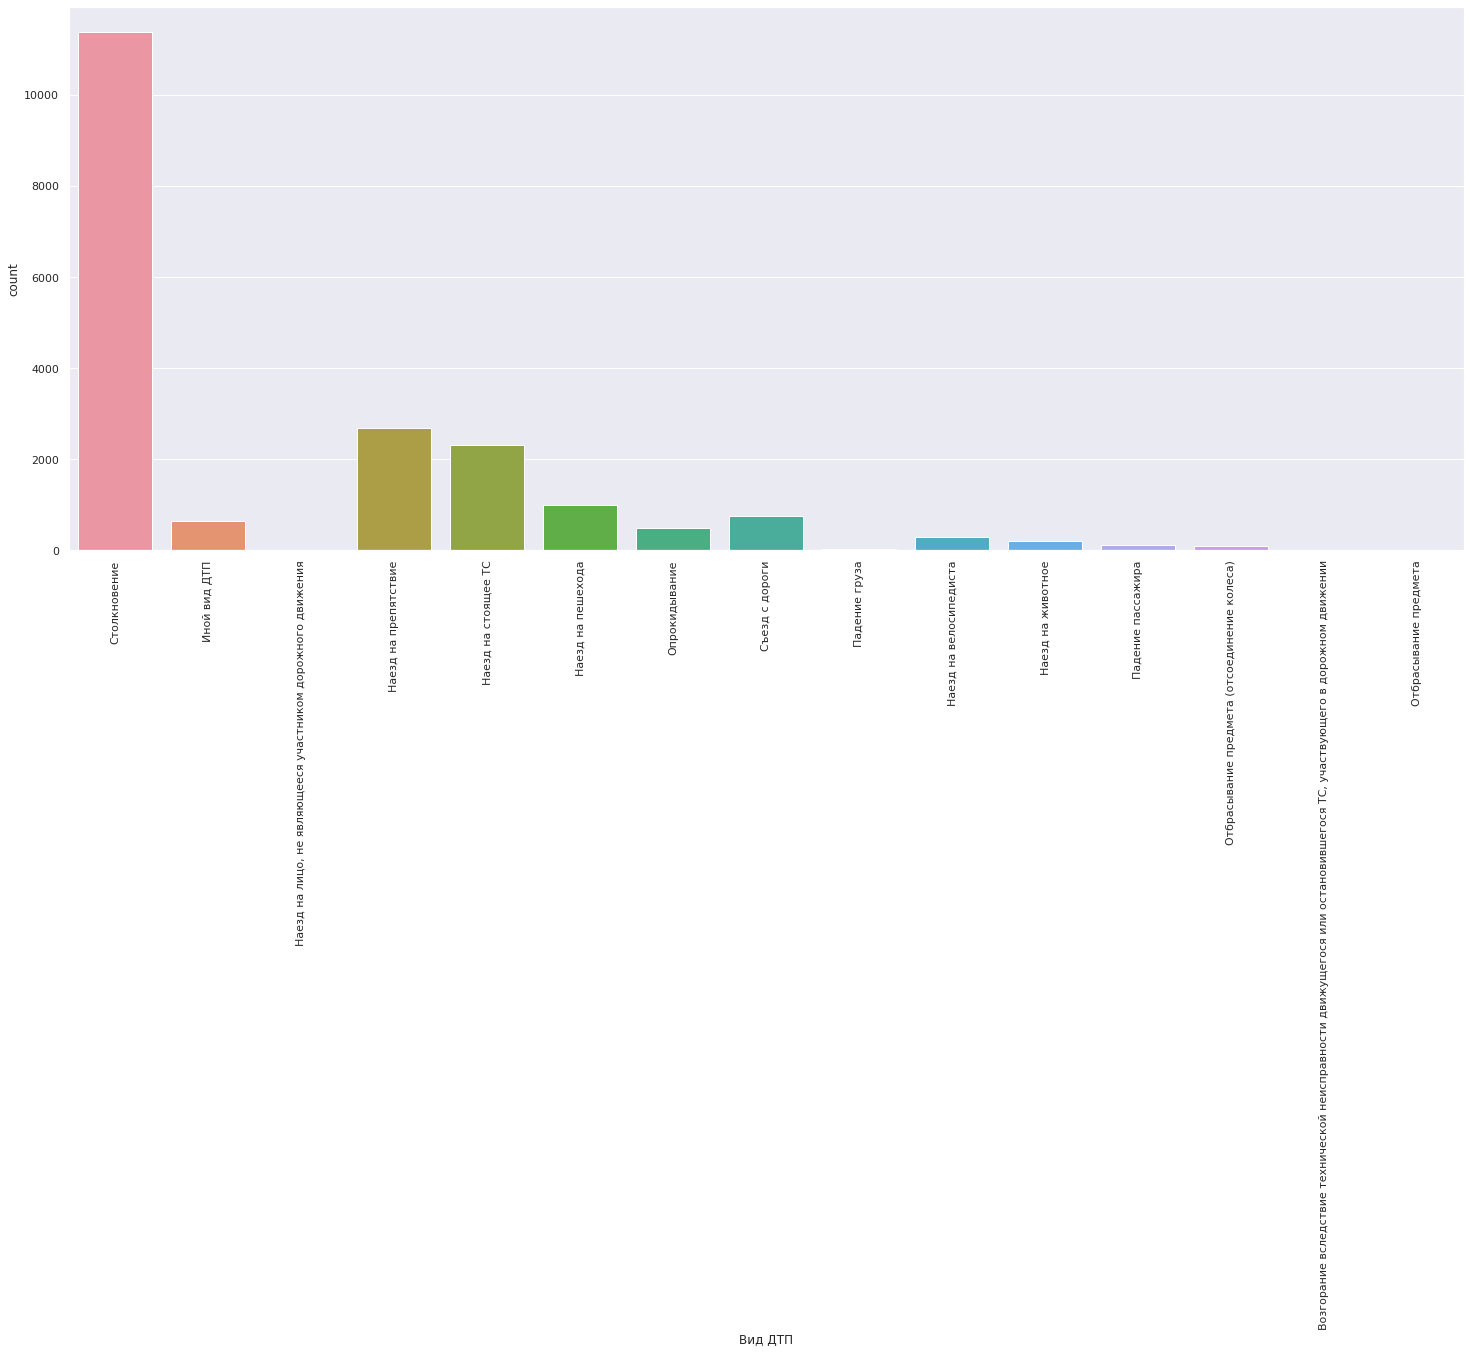

In [ ]:
plt.xticks(rotation=90)
sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(x = "Вид ДТП" , data  = df_train)  

#### Визуализация

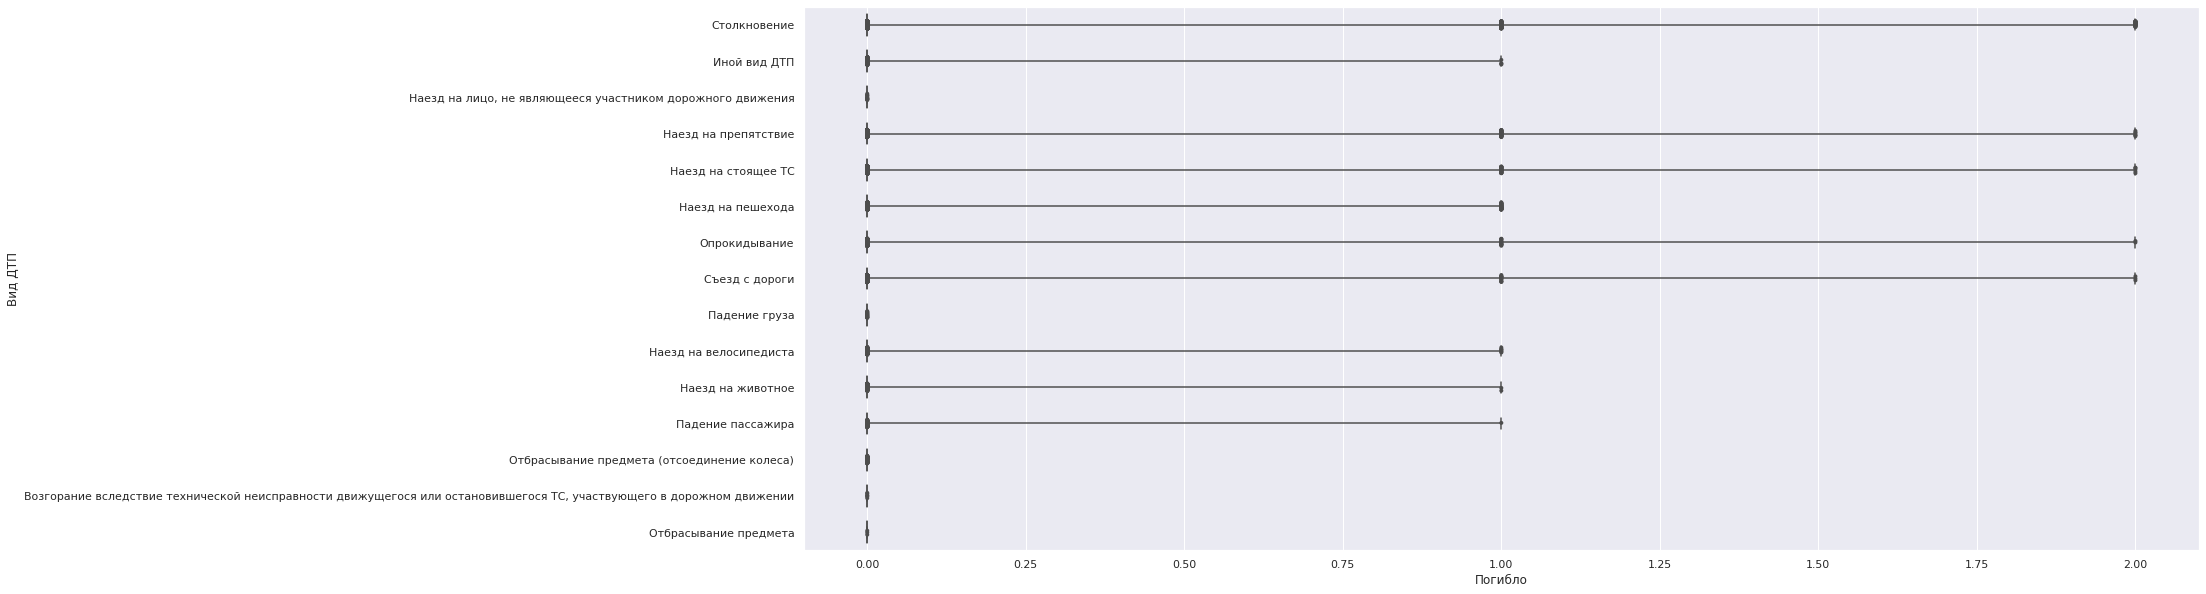

In [ ]:
sns.set(rc={'figure.figsize':(25,10)})

sns.boxplot(x="Погибло", y="Вид ДТП", data=df_train,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="Погибло", y="Вид ДТП", data=df_train,
              size=4, color=".3", linewidth=0)

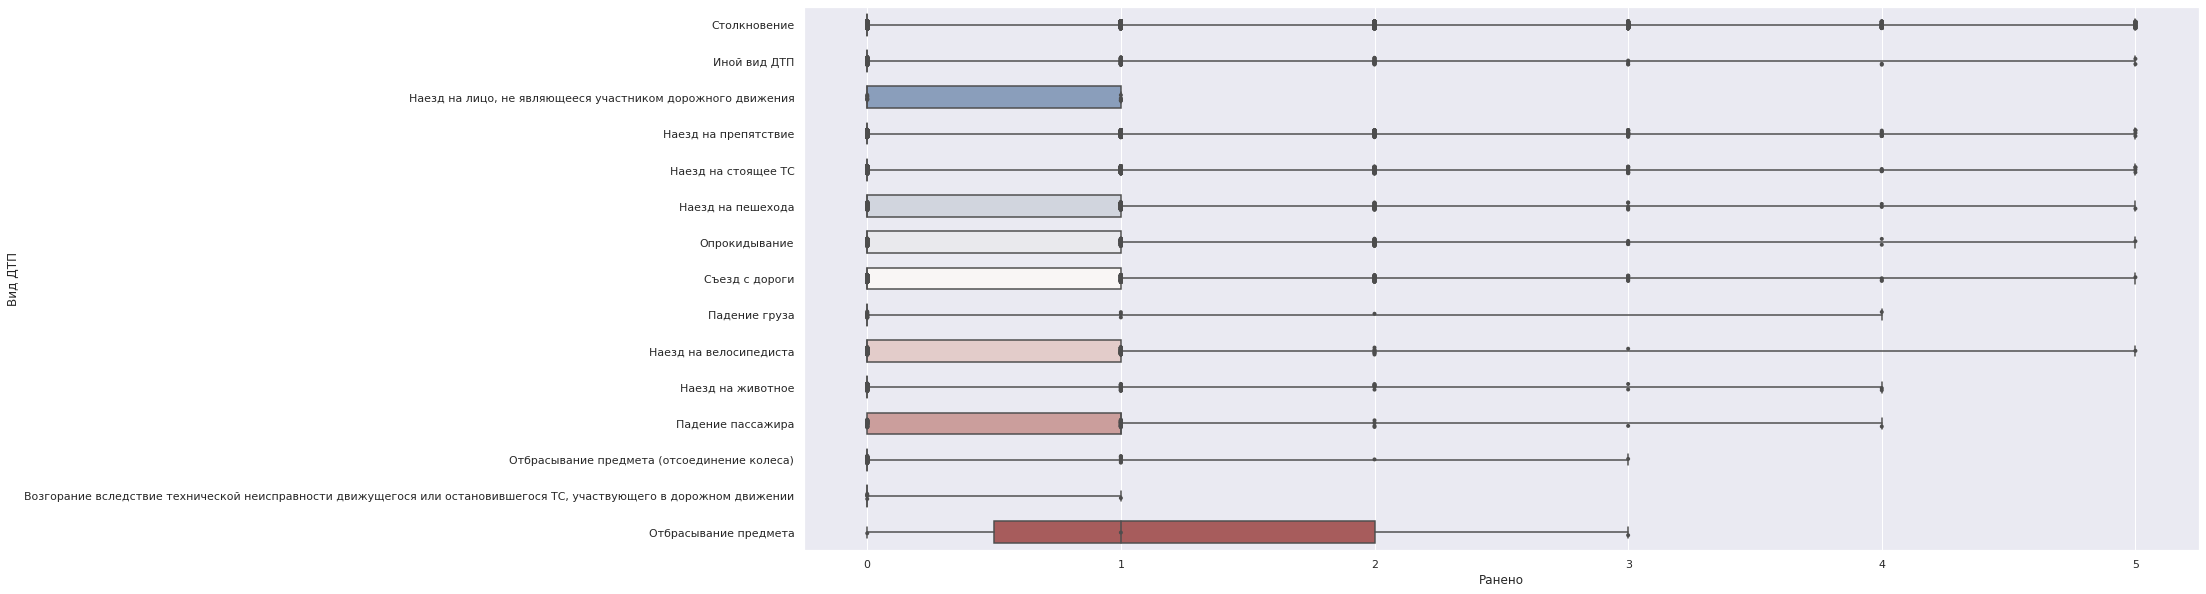

In [ ]:
sns.boxplot(x="Ранено", y="Вид ДТП", data=df_train,
            whis=[0, 100], width=.6, palette="vlag")
sns.stripplot(x="Ранено", y="Вид ДТП", data=df_train,
              size=4, color=".3", linewidth=0)

### Место

In [ ]:
zero_deads = set(df_train[(df_train['Погибло'] == 0) & (df_train['Ранено'] == 0)]['Место'].unique())

In [ ]:
one_more_deads = set(df_train[(df_train['Погибло'] != 0) | (df_train['Ранено'] != 0)]['Место'].unique())

In [ ]:
useless_places = zero_deads - one_more_deads

In [ ]:
df_train['Были смерти и ранения. Место'] = df_train['Место'].apply(lambda x: 0 if x in useless_places else 1)
df_test['Были смерти и ранения. Место'] = df_test['Место'].apply(lambda x: 0 if x in useless_places else 1)

In [ ]:
df_train['Токены места'] = df_train['Место'].apply(lambda x: x.split(','))
df_train['Район'] = df_train['Токены места'].apply(lambda x: x[1].strip() if len(x) >= 2 else 'Отсутствует район')
df_train['Округ'] = df_train['Токены места'].apply(lambda x: x[2].strip() if len(x) >= 3 else 'Отсутствует округ')
df_train['Город'] = df_train['Токены места'].apply(lambda x: x[3].strip() if len(x) >= 4 else 'Отсутствует город')

df_test['Токены места'] = df_test['Место'].apply(lambda x: x.split(','))
df_test['Район'] = df_test['Токены места'].apply(lambda x: x[1].strip() if len(x) >= 2 else 'Отсутствует район')
df_test['Округ'] = df_test['Токены места'].apply(lambda x: x[2].strip() if len(x) >= 3 else 'Отсутствует округ')
df_test['Город'] = df_test['Токены места'].apply(lambda x: x[3].strip() if len(x) >= 4 else 'Отсутствует город')

In [ ]:
unnessasary_city_set = set(df_train['Город'].unique()) - set(df_test['Город'].unique())

In [ ]:
df_train = df_train[~df_train["Город"].isin(unnessasary_city_set)].reset_index(drop=True)

### Погода

In [ ]:
union_data = df_train.drop(["Ранено", "Ранено детей", "Погибло", "Погибло детей"], axis=1).append(df_test)

In [ ]:
weather_per_week = union_data[["Год", "Неделя", "Район", "weather"]].groupby(by=["Год", 'Неделя', "Район"]).agg(lambda x: x.mode() if len(x) >= 1 else []).rename({'weather': 'Погода'}, axis=1)
weather_per_week['Погода'] = weather_per_week['Погода'].apply(lambda x: 'Неизвестно' if type(x) == np.ndarray else x)

df_train.loc[:, 'weather'] = df_train.loc[:, 'weather'].fillna(df_train.merge(weather_per_week, how='left', on=["Год", 'Неделя', "Район"])['Погода'])
df_test.loc[:, 'weather'] = df_test.loc[:, 'weather'].fillna(df_test.merge(weather_per_week, how='left', on=["Год", 'Неделя', "Район"])['Погода'])

#### Состояние дороги

In [ ]:
union_data = df_train.drop(["Ранено", "Ранено детей", "Погибло", "Погибло детей"], axis=1).append(df_test)

In [ ]:
condition_per_weather = union_data[["Год", "Неделя", "Район", "weather", "road_conditions"]].groupby(by=["Год", "Неделя", "Район", "weather"]).agg(lambda x: x.mode() if len(x) >= 1 else []).rename({'"road_conditions"': 'Состояние дороги'}, axis=1)
condition_per_weather['road_conditions'] = condition_per_weather['road_conditions'].apply(lambda x: 'Неизвестно' if type(x) == np.ndarray else x)

In [ ]:
df_train['Состояние дороги'] = df_train.loc[:, 'road_conditions'].fillna(df_train.merge(condition_per_weather, how='left', on=["Год", "Неделя", "Район", "weather"])['road_conditions_y'])
df_test['Состояние дороги'] = df_test.loc[:, 'road_conditions'].fillna(df_test.merge(condition_per_weather, how='left', on=["Год", "Неделя", "Район", "weather"])['road_conditions_y'])

In [ ]:
df_test.drop(['road_conditions'], inplace=True, axis=1)
df_train.drop(['road_conditions'], inplace=True, axis=1)

### Улица

#### Заполнение пропусков

In [ ]:
street_per_year_month = union_data[["Год_Месяц", "Место", "Вид ДТП", "Улица"]].groupby(by=['Год_Месяц', "Место", "Вид ДТП"]).agg(lambda x: x.mode() if len(x) >= 2 else np.array(x)).rename({'Улица': 'Улица 2'}, axis=1)

In [ ]:
street_per_year_month['Улица 2'] = street_per_year_month['Улица 2'].apply(lambda x: np.nan if type(x) == np.ndarray else x)

In [ ]:
df_train['Улица'].fillna(df_train.merge(street_per_year_month, how='left', on=['Год_Месяц', "Место", "Вид ДТП"])['Улица 2'], inplace=True)
df_test['Улица'].fillna(df_test.merge(street_per_year_month, how='left', on=['Год_Месяц', "Место", "Вид ДТП"])['Улица 2'], inplace=True)

df_train['Улица'].fillna('Неизвестно', inplace=True)
df_test['Улица'].fillna('Неизвестно', inplace=True)

In [ ]:
zero_deads = set(df_train[(df_train['Погибло'] == 0) & (df_train['Ранено'] == 0)]['Улица'].unique())

one_more_deads = set(df_train[(df_train['Погибло'] != 0) | (df_train['Ранено'] != 0)]['Улица'].unique())

In [ ]:
useless_streets = zero_deads - one_more_deads

In [ ]:
df_train['Были смерти и ранения. Улица'] = df_train['Улица'].apply(lambda x: 0 if x in useless_streets else 1)
df_test['Были смерти и ранения. Улица'] = df_test['Улица'].apply(lambda x: 0 if x in useless_streets else 1)

In [ ]:
unnessasary_street_set = set(df_train['Улица'].unique()) - set(df_test['Улица'].unique())
df_train['Улица'] = df_train['Улица'].apply(lambda x: 'Неважно' if x in unnessasary_street_set else x)

#### Выделение типа улицы

In [ ]:
df_train['Токены улицы'] = df_train['Улица'].apply(lambda x: str(x).split(' '))
df_test['Токены улицы'] = df_test['Улица'].apply(lambda x: str(x).split(' '))

df_train['Тип улицы'] = df_train['Токены улицы'].apply(lambda x: x[-1].strip() if len(x) >= 2 else 'Неизвестно')
df_test['Тип улицы'] = df_test['Токены улицы'].apply(lambda x: x[-1].strip() if len(x) >= 2 else 'Неизвестно')

In [ ]:
def delete_unknown_street_types(street_type):
  if street_type == '1"':
    return 'Неизвестно'
  if street_type == '1' or street_type == '5' or street_type == '3':
    return 'комплекс'
  else:
    return street_type

In [ ]:
df_test['Тип улицы'] = df_test['Тип улицы'].apply(delete_unknown_street_types)
df_train['Тип улицы'] = df_train['Тип улицы'].apply(delete_unknown_street_types)

### Визуализация локаций

In [ ]:
https://seaborn.pydata.org/tutorial/categorical.html

SyntaxError: ignored

In [ ]:
sns.catplot(x="Ранено", y="Район", row="Вид ДТП",
                kind="box", orient="h", aspect=4,
                data=df_train)

In [ ]:
sns.catplot(x="Погибло", y="Район", row="Вид ДТП",
                kind="box", orient="h", aspect=4,
                data=df_train)

In [ ]:
sns.catplot(x="Погибло", y='Вид ДТП', row='Тип улицы',
                kind="box", orient="h", aspect=4,
                data=df_train)

In [ ]:
sns.catplot(x="Ранено", y='Вид ДТП', row='Тип улицы',
                kind="box", orient="h", aspect=4,
                data=df_train)

### Дом

In [ ]:
union_data = df_train.drop(["Ранено", "Ранено детей", "Погибло", "Погибло детей"], axis=1).append(df_test).drop(['Токены улицы', 'Токены места'], axis=1).drop_duplicates()

In [ ]:
house_per_street = union_data[["Год_Месяц", "Дом", "Вид ДТП", "Улица"]].groupby(by=['Год_Месяц', "Вид ДТП", "Улица"]).agg(lambda x: x.mode() if len(x) > 2 else np.array(x)).rename({'Дом': 'Дом 2'}, axis=1)

In [ ]:
def preproc_house(x):
  if type(x) == np.ndarray:
    if len(x) >= 1:
      return x[0]
    else:
      return np.nan
  else:
    return x

In [ ]:
house_per_street['Дом 2'] = house_per_street['Дом 2'].apply(preproc_house)

In [ ]:
df_train['Дом'].fillna(df_train.merge(house_per_street, how='left', on=['Год_Месяц', "Вид ДТП", "Улица"])['Дом 2'], inplace=True)
df_test['Дом'].fillna(df_test.merge(house_per_street, how='left', on=['Год_Месяц', "Вид ДТП", "Улица"])['Дом 2'], inplace=True)

df_train['Дом'].fillna('Неизвестно', inplace=True)
df_test['Дом'].fillna('Неизвестно', inplace=True)

In [ ]:
def house_proc(x):
  x = str(x)
  if x in ['*', '-', '.']:
    return 'неизвестно'
  if x.lower() in ['бн', 'б/н', 'б\\н', 'б.н']:
      return 'б/н'
  if x.lower() in ['бспб', 'бспетербургск.', 'бспетербургск', 'путепровод к бспб']:
      return 'бспб'
  if x.lower() in ['подх. к синему мост', 'подх. к синему мосту']:
      return 'подх. к синему мосту'
  if x.lower() == 'деревяницкий мост':
    return 'съезд с дерев. моста'
  if x.lower() in ['б. московской', 'бол.московской', 'бол. московс']:
    return 'б. московской'
  if x.lower().strip() in ['колмовск. мост спуск', 'подход к колм. мосту']:
    return 'колмовский мост'

  if not any([char.isdigit() for char in x]):
    return x.lower().strip()
  if x.find(' по ул ') != -1:
    if x.split(' по ул ')[1].lower() in ['бн', 'б/н', 'б\\н']:
      return 'б/н'
    if x.split(' по ул ')[1].lower() in ['бспб', 'бспетербургск.', 'бспетербургск']:
      return 'бспб'
    if x.split(' по ул ')[1].lower() in ['б. московской', 'бол.московской', 'бол. московс']:
      return 'б. московской'
    return x.split(' по ул ')[1].lower().strip()
  if x.find(' по ул.')  != -1:
    if x.split(' по ул.')[1].lower() in ['бн', 'б/н', 'б\\н']:
      return 'б/н'
    if x.split(' по ул.')[1].lower() in ['бспб', 'бспетербургск.', 'бспетербургск']:
      return 'бспб'
    if x.split(' по ул. ')[1].lower() in ['б. московской', 'бол.московской', 'бол. московс']:
      return 'б. московской'
    return x.split(' по ул.')[1].lower().strip()
  if x.find(' по ') != -1:
    if x.split(' по ')[1].lower() in ['бн', 'б/н', 'б\\н']:
      return 'б/н'
    if x.split(' по ')[1].lower() in ['бспб', 'бспетербургск.', 'бспетербургск']:
      return 'бспб'
    if x.split(' по ')[1].lower() in ['б. московской', 'бол.московской', 'бол. московс']:
      return 'б. московской'
    return x.split(' по ')[1].lower().strip()
  if x.find(' у ') != -1:
    if x.split(' у ')[0].lower() in ['бн', 'б/н', 'б\\н']:
      return 'б/н'
    if x.split(' у ')[0].lower() in ['подх. к синему мост', 'подх. к синему мосту']:
      return 'подх. к синему мосту'
    if x.split(' у ')[0].lower() in ['бспб', 'бспетербургск.', 'бспетербургск']:
      return 'бспб'
    if x.split(' у ')[1].lower() in ['б. московской', 'бол.московской', 'бол. московс']:
      return 'б. московской'
    return x.split(' у ')[0].lower().strip()
  
  return 'неизвестно'

In [ ]:
df_train['Название возле дома'] = df_train['Дом'].apply(house_proc)
df_test['Название возле дома'] = df_test['Дом'].apply(house_proc)

In [ ]:
unnessasary_street_set = set(df_train['Название возле дома'].unique()) - set(df_test['Название возле дома'].unique())
df_train['Название возле дома'] = df_train['Название возле дома'].apply(lambda x: 'Неважно' if x in unnessasary_street_set else x)

In [ ]:
unnessasary_street_set = set(df_train['Дом'].unique()) - set(df_test['Дом'].unique())
df_train['Дом'] = df_train['Дом'].apply(lambda x: 'Неважно' if x in unnessasary_street_set else x)

### Дорога

In [ ]:
road_per_street = union_data[["Год_Месяц", "Район", "Вид ДТП", "Дорога"]].groupby(by=['Год_Месяц', "Район", "Вид ДТП"]).agg(lambda x: x.mode() if len(x) >= 2 else np.array(x)).rename({'Дорога': 'Дорога 2'}, axis=1)

In [ ]:
def preproc_house(x):
  if type(x) == np.ndarray:
    if len(x) >= 1:
      return x[0]
    else:
      return np.nan
  else:
    return x

In [ ]:
road_per_street['Дорога 2'] = road_per_street['Дорога 2'].apply(preproc_house)

In [ ]:
df_train['Дорога'].fillna(df_train.merge(road_per_street, how='left', on=['Год_Месяц', "Вид ДТП", "Район"])['Дорога 2'], inplace=True)
df_test['Дорога'].fillna(df_test.merge(road_per_street, how='left', on=['Год_Месяц', "Вид ДТП", "Район"])['Дорога 2'], inplace=True)

df_train['Дорога'].fillna('Неизвестно', inplace=True)
df_test['Дорога'].fillna('Неизвестно', inplace=True)

In [ ]:
unnessasary_road_set = set(df_train['Дорога'].unique()) - set(df_test['Дорога'].unique())
df_train['Дорога'] = df_train['Дорога'].apply(lambda x: 'Неважно' if x in unnessasary_road_set else x)

In [ ]:
zero_deads = set(df_train[(df_train['Погибло'] == 0) & (df_train['Ранено'] == 0)]['Дорога'].unique())

one_more_deads = set(df_train[(df_train['Погибло'] != 0) | (df_train['Ранено'] != 0)]['Дорога'].unique())

In [ ]:
useless_roads = zero_deads - one_more_deads

In [ ]:
df_train['Были смерти и ранения. Дорога'] = df_train['Дорога'].apply(lambda x: 0 if x in useless_streets else 1)
df_test['Были смерти и ранения. Дорога'] = df_test['Дорога'].apply(lambda x: 0 if x in useless_streets else 1)

### Километр

In [ ]:
df_train["Километр"] = df_train["Километр"].apply(lambda x: pd.to_numeric(x) if type(x) in [int, float] else np.nan)
df_test["Километр"] = df_test["Километр"].apply(lambda x: pd.to_numeric(x) if type(x) in [int, float] else np.nan)

In [ ]:
union_data = df_train.drop(['Токены улицы', 'Токены места'], axis=1).append(df_test.drop(['Токены улицы', 'Токены места'], axis=1)).drop_duplicates()

In [ ]:
kilo_per_street = union_data[["Год_Месяц", "Дорога", "Вид ДТП", "Километр"]].groupby(by=["Год_Месяц", "Дорога", "Вид ДТП"]).agg(lambda x: x.mean() if len(x) >= 2 else np.array(x)).rename({'Километр': 'Километр 2'}, axis=1)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


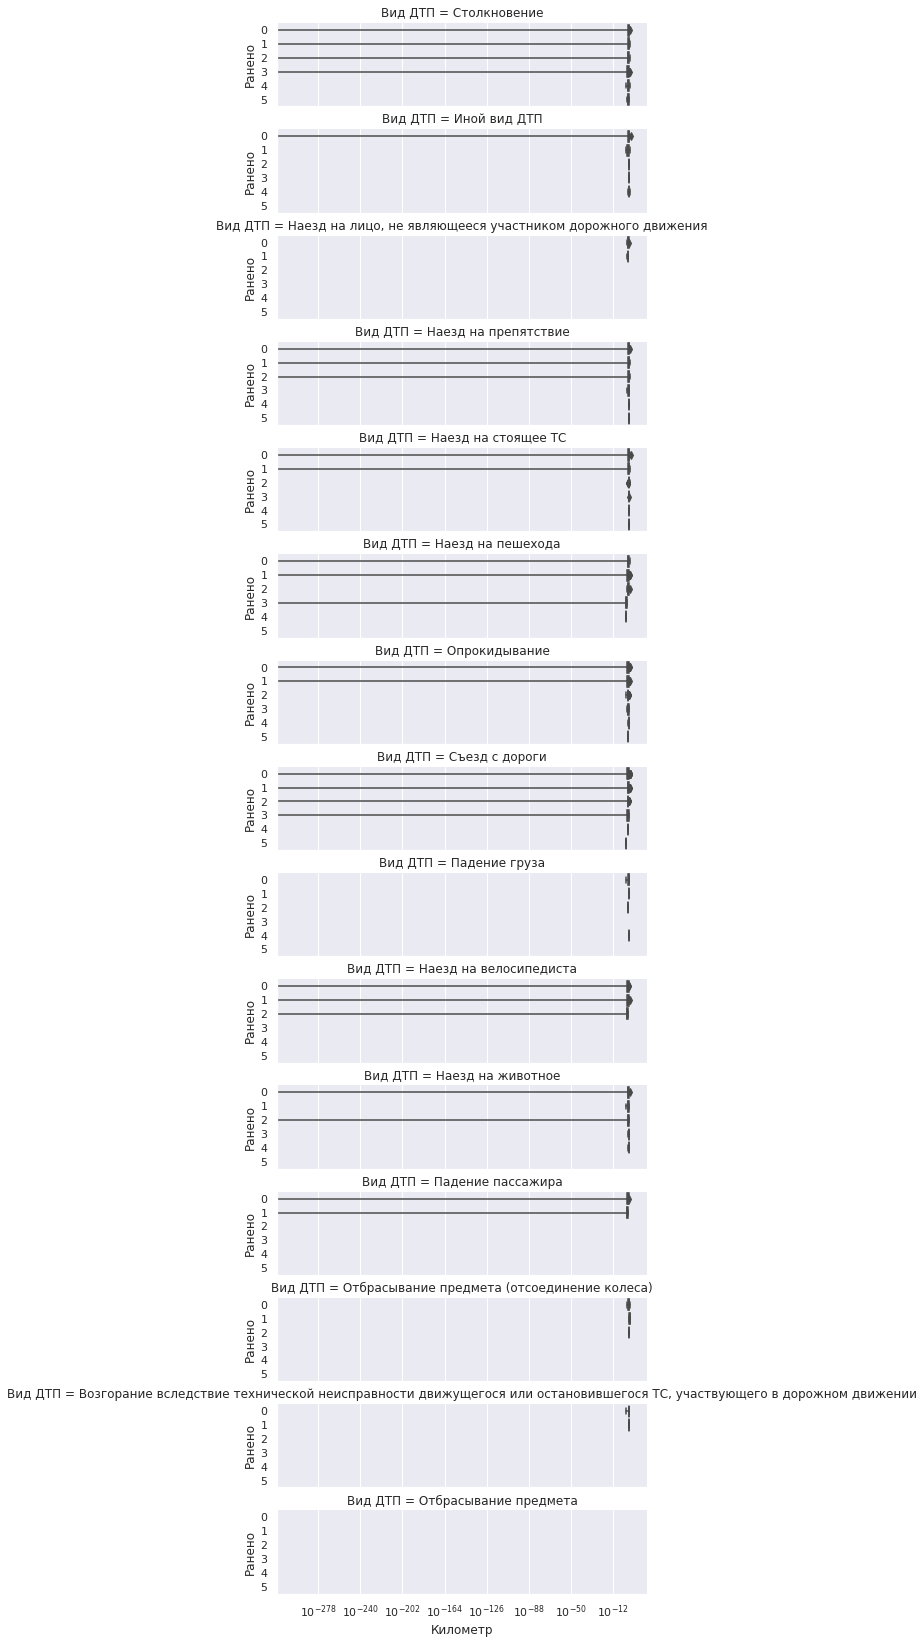

In [ ]:
g = sns.catplot(x="Километр", y="Ранено", row="Вид ДТП",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
g.set(xscale="log")

In [ ]:
df_train['Километр'].fillna(df_train.merge(kilo_per_street, how='left', on=["Год_Месяц", "Дорога", "Вид ДТП"])['Километр 2'], inplace=True)
df_test['Километр'].fillna(df_test.merge(kilo_per_street, how='left', on=["Год_Месяц", "Дорога", "Вид ДТП"])['Километр 2'], inplace=True)

df_train['Километр'].fillna(-np.inf, inplace=True)
df_test['Километр'].fillna(-np.inf, inplace=True)

### Метр

In [ ]:
df_train["Метр"] = pd.to_numeric(df_train["Метр"])
df_test["Метр"] = pd.to_numeric(df_test["Метр"])

In [ ]:
union_data = df_train.drop(['Токены улицы', 'Токены места'], axis=1).append(df_test.drop(['Токены улицы', 'Токены места'], axis=1)).drop_duplicates()

In [ ]:
metr_per_street = union_data[["Год_Месяц", "Дорога", "Вид ДТП", "Километр", "Метр"]].groupby(by=["Год_Месяц", "Дорога", "Вид ДТП", "Километр"]).agg(lambda x: x.mean() if len(x) >= 1 else np.array(x)).rename({'Метр': 'Метр 2'}, axis=1)

In [ ]:
df_train['Метр'].fillna(df_train.merge(metr_per_street, how='left', on=["Год_Месяц", "Дорога", "Вид ДТП", "Километр"])['Метр 2'], inplace=True)
df_test['Метр'].fillna(df_test.merge(metr_per_street, how='left', on=["Год_Месяц", "Дорога", "Вид ДТП", "Километр"])['Метр 2'], inplace=True)

df_train['Метр'].fillna(-np.inf, inplace=True)
df_test['Метр'].fillna(-np.inf, inplace=True)

## Предобработка

### Обработаем категориальные признаки

In [ ]:
onehot_place = OneHotEncoder(handle_unknown='ignore', sparse=False)

places = pd.DataFrame(onehot_place.fit_transform(df_train['Район'].values.reshape(-1, 1)), columns=['Район_' + str(name) for name in onehot_place.categories_[0]])
df_train = pd.concat([df_train, places], axis=1)

places = pd.DataFrame(onehot_place.transform(df_test['Район'].values.reshape(-1, 1)), columns=['Район_' + str(name) for name in onehot_place.categories_[0]])
df_test = pd.concat([df_test, places], axis=1)

In [ ]:
onehot_okrug = OneHotEncoder(handle_unknown='ignore', sparse=False)

okrugs = pd.DataFrame(onehot_okrug.fit_transform(df_train['Округ'].values.reshape(-1, 1)), columns=['Округ_' + str(name) for name in onehot_okrug.categories_[0]])
df_train = pd.concat([df_train, okrugs], axis=1)

okrugs = pd.DataFrame(onehot_okrug.transform(df_test['Округ'].values.reshape(-1, 1)), columns=['Округ_' + str(name) for name in onehot_okrug.categories_[0]])
df_test = pd.concat([df_test, okrugs], axis=1)

In [ ]:
onehot_city = OneHotEncoder(handle_unknown='ignore', sparse=False)

cities = pd.DataFrame(onehot_city.fit_transform(df_train['Город'].values.reshape(-1, 1)), columns=['Город_' + str(name) for name in onehot_city.categories_[0]])
df_train = pd.concat([df_train, cities], axis=1)

cities = pd.DataFrame(onehot_city.transform(df_test['Город'].values.reshape(-1, 1)), columns=['Город_' + str(name) for name in onehot_city.categories_[0]])
df_test = pd.concat([df_test, cities], axis=1)

In [ ]:
onehot_road = OneHotEncoder(handle_unknown='ignore', sparse=False)

roads = pd.DataFrame(onehot_road.fit_transform(df_train['Дорога'].values.reshape(-1, 1)), columns=['Дорога_' + str(name) for name in onehot_road.categories_[0]])
df_train = pd.concat([df_train, roads], axis=1)

roads = pd.DataFrame(onehot_road.transform(df_test['Дорога'].values.reshape(-1, 1)), columns=['Дорога_' + str(name) for name in onehot_road.categories_[0]])
df_test = pd.concat([df_test, roads], axis=1)

In [ ]:
onehot_DTP = OneHotEncoder(handle_unknown='ignore', sparse=False)

DTPs = pd.DataFrame(onehot_DTP.fit_transform(df_train['Вид ДТП'].values.reshape(-1, 1)), columns=['Вид ДТП_' + str(name) for name in onehot_DTP.categories_[0]])
df_train = pd.concat([df_train, DTPs], axis=1)

DTPs = pd.DataFrame(onehot_DTP.transform(df_test['Вид ДТП'].values.reshape(-1, 1)), columns=['Вид ДТП_' + str(name) for name in onehot_DTP.categories_[0]])
df_test = pd.concat([df_test, DTPs], axis=1)

In [ ]:
onehot_street = OneHotEncoder(handle_unknown='ignore', sparse=False)

streets = pd.DataFrame(onehot_street.fit_transform(df_train['Улица'].values.reshape(-1, 1)), columns=['Улица_' + str(name) for name in onehot_street.categories_[0]])
df_train = pd.concat([df_train, streets], axis=1)

streets = pd.DataFrame(onehot_street.transform(df_test['Улица'].values.reshape(-1, 1)), columns=['Улица_' + str(name) for name in onehot_street.categories_[0]])
df_test = pd.concat([df_test, streets], axis=1)

In [ ]:
onehot_street_type = OneHotEncoder(handle_unknown='ignore', sparse=False)

street_types = pd.DataFrame(onehot_street_type.fit_transform(df_train['Тип улицы'].values.reshape(-1, 1)), columns=['Тип улицы_' + str(name) for name in onehot_street_type.categories_[0]])
df_train = pd.concat([df_train, street_types], axis=1)

street_types = pd.DataFrame(onehot_street_type.transform(df_test['Тип улицы'].values.reshape(-1, 1)), columns=['Тип улицы_' + str(name) for name in onehot_street_type.categories_[0]])
df_test = pd.concat([df_test, street_types], axis=1)

In [ ]:
onehot_house = OneHotEncoder(handle_unknown='ignore', sparse=False)

houses = pd.DataFrame(onehot_house.fit_transform(df_train['Дом'].values.reshape(-1, 1)), columns=['Дом_' + str(name) for name in onehot_house.categories_[0]])
df_train = pd.concat([df_train, houses], axis=1)

houses = pd.DataFrame(onehot_house.transform(df_test['Дом'].values.reshape(-1, 1)), columns=['Дом_' + str(name) for name in onehot_house.categories_[0]])
df_test = pd.concat([df_test, houses], axis=1)

In [ ]:
onehot_corpus = OneHotEncoder(handle_unknown='ignore', sparse=False)

corpuses = pd.DataFrame(onehot_corpus.fit_transform(df_train['Название возле дома'].values.reshape(-1, 1)), columns=['Название возле дома_' + str(name) for name in onehot_corpus.categories_[0]])
df_train = pd.concat([df_train, corpuses], axis=1)

corpuses = pd.DataFrame(onehot_corpus.transform(df_test['Название возле дома'].values.reshape(-1, 1)), columns=['Название возле дома_' + str(name) for name in onehot_corpus.categories_[0]])
df_test = pd.concat([df_test, corpuses], axis=1)

In [ ]:
onehot_severity = OneHotEncoder(handle_unknown='ignore', sparse=False)

severities = pd.DataFrame(onehot_severity.fit_transform(df_train['severity'].values.reshape(-1, 1)), columns=['Категория ДТП_' + str(name) for name in onehot_severity.categories_[0]])
df_train = pd.concat([df_train, severities], axis=1)

severities = pd.DataFrame(onehot_severity.transform(df_test['severity'].values.reshape(-1, 1)), columns=['Категория ДТП_' + str(name) for name in onehot_severity.categories_[0]])
df_test = pd.concat([df_test, severities], axis=1)

In [ ]:
onehot_weather = OneHotEncoder(handle_unknown='ignore', sparse=False)

weathers = pd.DataFrame(onehot_weather.fit_transform(df_train['weather'].values.reshape(-1, 1)), columns=['Погода_' + str(name) for name in onehot_weather.categories_[0]])
df_train = pd.concat([df_train, weathers], axis=1)

weathers = pd.DataFrame(onehot_weather.transform(df_test['weather'].values.reshape(-1, 1)), columns=['Погода_' + str(name) for name in onehot_weather.categories_[0]])
df_test = pd.concat([df_test, weathers], axis=1)

In [ ]:
onehot_cond = OneHotEncoder(handle_unknown='ignore', sparse=False)

conds = pd.DataFrame(onehot_cond.fit_transform(df_train['Состояние дороги'].values.reshape(-1, 1)), columns=['Состояние дороги_' + str(name) for name in onehot_cond.categories_[0]])
df_train = pd.concat([df_train, conds], axis=1)

conds = pd.DataFrame(onehot_cond.transform(df_test['Состояние дороги'].values.reshape(-1, 1)), columns=['Состояние дороги_' + str(name) for name in onehot_cond.categories_[0]])
df_test = pd.concat([df_test, conds], axis=1)

## Выделим выборки

In [ ]:
X = df_train.drop(["Дата", "Время","Место", 'Название возле дома', "Токены места", "Место",
                   "Район", "Округ", "Город", "Дорога", "Улица", 'Токены улицы', 'Тип улицы', "Дом", "id", "Вид ДТП", 
                   "Погибло",	"Погибло детей",	"Ранено",	"Ранено детей", 'severity', 'weather', 'Состояние дороги', 'datetime'], axis = 1)
y = df_train[["Погибло",	"Погибло детей",	"Ранено",	"Ранено детей"]]

X_to_predict = df_test.drop(["Дата", "Время", 'Название возле дома', "Токены места", 
                             "Место", "Район", "Округ", "Город", "Дорога", "Улица", 'Токены улицы', 'Тип улицы', 
                             "Дом", "id", "Вид ДТП", 'severity', 'weather', 'Состояние дороги', 'datetime'], axis = 1)

## Feature Selection

In [ ]:
reg1 = CatBoostRegressor(random_seed=0, verbose=False)
reg2 = CatBoostRegressor(random_seed=0, verbose=False)
reg3 = CatBoostRegressor(random_seed=0, verbose=False)
reg4 = CatBoostRegressor(random_seed=0, verbose=False)

reg1.fit(X, y["Погибло"])

pred1 = abs(np.round(reg1.predict(X)))

X_d = X.copy()
X_d.loc[:, "Погибло"] = pred1

reg2.fit(X_d, y["Ранено"])

pred2 = abs(np.round(reg2.predict(X_d)))

X_db = X_d.copy()
X_db.loc[:, "Ранено"] = pred2

reg3.fit(X_db, y["Погибло детей"])

reg4.fit(X_db, y["Ранено детей"])

### SHAP

In [ ]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

In [ ]:
fi_reg1 = global_shap_importance(reg1, X)
fi_reg2 = global_shap_importance(reg2, X_d)
fi_reg3 = global_shap_importance(reg3, X_db)
fi_reg4 = global_shap_importance(reg4, X_db)

fi_reg1.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg1.csv', index=False)
fi_reg2.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg2.csv', index=False)
fi_reg3.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg3.csv', index=False)
fi_reg4.to_csv('/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg4.csv', index=False)

## Валидация модели

In [ ]:
fi_reg1 = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg1.csv")
fi_reg2 = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg2.csv")
fi_reg3 = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg3.csv")
fi_reg4 = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/DTP/fi_reg4.csv")

fi_reg1 = fi_reg1['features'].values[:450]
fi_reg2 = fi_reg2['features'].values[:650]
fi_reg3 = fi_reg3['features'].values[:300]
fi_reg4 = fi_reg4['features'].values[:555]

In [ ]:
def validate(X_train, y_train, X_test, y_test):

  reg1 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
  reg2 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
  reg3 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
  reg4 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')

  reg1.fit(X_train[fi_reg1], y_train["Погибло"], eval_set=(X_test[fi_reg1], y_test["Погибло"]), use_best_model=True)

  reg_pred1 = abs(np.round(reg1.predict(X_train[fi_reg1])))
  test_reg_pred1 = abs(np.round(reg1.predict(X_test[fi_reg1])))

  pred1 = reg_pred1

  X_train.loc[:, "Погибло"] = reg_pred1
  X_test.loc[:, "Погибло"] = test_reg_pred1

  reg2.fit(X_train[fi_reg2], y_train["Ранено"], eval_set=(X_test[fi_reg2], y_test["Ранено"]), use_best_model=True)

  reg_pred2 = abs(np.round(reg2.predict(X_train[fi_reg2])))
  test_reg_pred2 = abs(np.round(reg2.predict(X_test[fi_reg2])))

  pred2 = reg_pred2

  X_train.loc[:, "Ранено"] = reg_pred2
  X_test.loc[:, "Ранено"] = test_reg_pred2

  reg3.fit(X_train[fi_reg3], y_train["Погибло детей"], eval_set=(X_test[fi_reg3], y_test["Погибло детей"]), use_best_model=True)

  reg_pred3 = abs(np.round(reg3.predict(X_train[fi_reg3])))
  test_reg_pred3 = abs(np.round(reg3.predict(X_test[fi_reg3])))

  pred3 = reg_pred3

  reg4.fit(X_train[fi_reg4], y_train["Ранено детей"], eval_set=(X_test[fi_reg4], y_test["Ранено детей"]), use_best_model=True)

  reg_pred4 = abs(np.round(reg4.predict(X_train[fi_reg4])))
  test_reg_pred4 = abs(np.round(reg4.predict(X_test[fi_reg4])))

  pred4 = reg_pred4

  score_dead = recall_score(y_train["Погибло"], pred1, average='macro', zero_division=True)
  score_dead_children = recall_score(y_train["Погибло детей"], pred3, average='macro', zero_division=True)
  score_blood = recall_score(y_train["Ранено"], pred2, average='macro', zero_division=True)
  score_blood_children = recall_score(y_train["Ранено детей"], pred4, average='macro', zero_division=True)

  train_score = (score_dead + score_dead_children + score_blood + score_blood_children) / 4

  score_dead = recall_score(y_test["Погибло"], test_reg_pred1, average='macro', zero_division=True)
  score_dead_children = recall_score(y_test["Погибло детей"], test_reg_pred3, average='macro', zero_division=True)
  score_blood = recall_score(y_test["Ранено"], test_reg_pred2, average='macro', zero_division=True)
  score_blood_children = recall_score(y_test["Ранено детей"], test_reg_pred4, average='macro', zero_division=True)

  print('test score dead - ', score_dead)
  print('test score dead_children - ', score_dead_children)
  print('test score blood - ', score_blood)
  print('test score blood_children - ', score_blood_children)
  test_score = (score_dead + score_dead_children + score_blood + score_blood_children) / 4
  
  return train_score, test_score, reg1, reg2, reg3, reg4

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
train_scores = []
test_scores = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  print('new iteration')
  train_score, test_score, reg1, reg2, reg3, reg4 = validate(X_train, y_train, X_test, y_test)
  train_scores.append(train_score)
  test_scores.append(test_score)

  reg1.save_model(f'reg1_fold_{i}.cbm')
  reg2.save_model(f'reg2_fold_{i}.cbm')
  reg3.save_model(f'reg3_fold_{i}.cbm')
  reg4.save_model(f'reg4_fold_{i}.cbm')

print('train')
print(train_scores)
print(sum(train_scores) / kf.get_n_splits(X))
print('\n')
print('test')
print(test_scores)
print(sum(test_scores) / kf.get_n_splits(X))

# Одна модель

## Обучение одной модели

In [ ]:
reg1 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
reg2 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
reg3 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')
reg4 = CatBoostClassifier(random_seed=0, verbose=False, auto_class_weights='SqrtBalanced')

reg1.fit(X[fi_reg1], y["Погибло"])

pred1 = np.round(abs(reg1.predict(X[fi_reg1])))

X_d = X.copy()
X_d.loc[:, "Погибло"] = pred1

reg2.fit(X_d[fi_reg2], y["Ранено"])

pred2 = np.round(abs(reg2.predict(X_d[fi_reg2])))

X_db = X_d.copy()
X_db.loc[:, "Ранено"] = pred2

reg3.fit(X_db[fi_reg3], y["Погибло детей"])

pred3 = np.round(abs(reg3.predict(X_db[fi_reg3])))

reg4.fit(X_db[fi_reg4], y["Ранено детей"])

pred4 = np.round(abs(reg4.predict(X_db[fi_reg4])))

score_dead = recall_score(y["Погибло"], pred1, average='macro', zero_division=True)
score_dead_children = recall_score(y["Погибло детей"], pred3, average='macro', zero_division=True)
score_blood = recall_score(y["Ранено"], pred2, average='macro', zero_division=True)
score_blood_children = recall_score(y["Ранено детей"], pred4, average='macro', zero_division=True)

print('train score dead - ', score_dead)
print('train score dead_children - ', score_dead_children)
print('train score blood - ', score_blood)
print('train score blood_children - ', score_blood_children)

train_score = (score_dead + score_dead_children + score_blood + score_blood_children) / 4

print('Overall Recall - ', train_score)

train score dead -  0.9463067573124492
train score dead_children -  0.9997191441556452
train score blood -  0.7193179369999158
train score blood_children -  0.8103204714239588
Overall Recall -  0.8689160774729923


## Сабмит одной модели

In [ ]:
pred1 = np.round(abs(reg1.predict(X_to_predict)))

X_d = X_to_predict.copy()
X_d.loc[:, "Погибло"] = pred1

pred2 = np.round(abs(reg2.predict(X_d)))

X_db = X_d.copy()
X_db.loc[:, "Ранено"] = pred2

pred3 = np.round(abs(reg3.predict(X_db)))

pred4 = np.round(abs(reg4.predict(X_db)))

In [ ]:
submit = pd.DataFrame({"Погибло": pred1.flatten(),	"Погибло детей": pred3.flatten(),	"Ранено": pred2.flatten(),	"Ранено детей": pred4.flatten()})

submit.insert(loc=0, column='id', value=df_test["id"])

In [ ]:
to_insert = common_rows[['id', 'Погибло',	'Погибло детей',	'Ранено',	'Ранено детей']].groupby(by='id').mean()
to_insert['Ранено'] = to_insert['Ранено'].apply(lambda x: 1 if x >= 0.5 else 0)
to_insert['Ранено детей'] = to_insert['Ранено детей'].apply(lambda x: 1 if x >= 0.5 else 0)
to_insert['Погибло'] = to_insert['Погибло'].apply(lambda x: 1 if x >= 0.5 else 0)
to_insert['Погибло детей'] = to_insert['Погибло детей'].apply(lambda x: 1 if x >= 0.5 else 0)
to_insert.reset_index(inplace=True)

In [ ]:
submit.loc[submit['id'].isin(to_insert['id']), ['Погибло',	'Погибло детей',	'Ранено',	'Ранено детей']] = np.nan

In [ ]:
to_insert_full = submit.merge(to_insert, how='left', on=['id'])

In [ ]:
submit.loc[submit['id'].isin(to_insert['id']), 'Погибло'] = submit.loc[submit['id'].isin(to_insert['id']), 'Погибло'].fillna(to_insert_full['Погибло_y'])
submit.loc[submit['id'].isin(to_insert['id']), 'Погибло детей'] = submit.loc[submit['id'].isin(to_insert['id']), 'Погибло детей'].fillna(to_insert_full['Погибло детей_y'])
submit.loc[submit['id'].isin(to_insert['id']), 'Ранено'] = submit.loc[submit['id'].isin(to_insert['id']), 'Ранено'].fillna(to_insert_full['Ранено_y'])
submit.loc[submit['id'].isin(to_insert['id']), 'Ранено детей'] = submit.loc[submit['id'].isin(to_insert['id']), 'Ранено детей'].fillna(to_insert_full['Ранено детей_y'])

In [ ]:
submit['Погибло'] = submit['Погибло'].apply(int)
submit['Погибло детей'] = submit['Погибло детей'].apply(int)
submit['Ранено'] = submit['Ранено'].apply(int)
submit['Ранено детей'] = submit['Ранено детей'].apply(int)

In [ ]:
submit = submit.set_index('id')

In [ ]:
submit.head()

,Погибло,Погибло детей,Ранено,Ранено детей
id,,,,
490078911,0,0,0,0
490055448,0,0,0,0
490054440,1,0,0,0
490037847,0,0,0,0
490037049,0,0,0,0


In [ ]:
submit.to_csv('sqrt_cut_features.csv')